<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
<center>Автор материала: Ольга Дайховская

# <center> Домашнее задание № 4. Часть 2. Решение
## <center>  Прогнозирование популярности статей на TechMedia с помощью линейных моделей

**В задании Вам предлагается разобраться с тем, как работает TfidfVectorizer и DictVectorizer, затем обучить и настроить модель линейной регрессии Ridge на данных о публикациях на Хабрахабре. Пройдя все шаги, вы сможете получить бейзлайн для [соревнования](https://inclass.kaggle.com/c/howpop-habrahabr-favs-lognorm). 
Ответьте на все вопросы в этой тетрадке и заполните ответы в [гугл-форме](https://docs.google.com/forms/d/e/1FAIpQLSd8E7naU38ikc9-rd31KeVfez3emCo4Ok1WrpQTr-XCDelRiw/viewform).**

**Описание соревнования**

Предскажите, как много звездочек наберет статья, зная только ее текст и время публикации

Необходимо предсказать популярность поста на Хабре по содержанию и времени публикации. Как известно, пользователи Хабра могут добавлять статьи к себе в избранное. Общее количество пользователей, которое это сделали отображается у статьи количеством звездочек. Будем считать, что число звездочек, поставленных статье, наиболее хорошо отражает ее популярность.

Более формально, в качестве метрики популярности статьи будем использовать долю статей за последний месяц, у которых количество звездочек меньше чем у текущей статьи. А точнее, доле числа звездочек можно поставить в соответствие квантили стандартного распределения, таким образом получаем числовую характеристику популярности статьи. Популярность статьи 0 означает, что статья получила ровно столько звездочек, сколько в среднем получают статьи. И соответственно чем больше звездочек получила статья по сравнению со средним, тем выше это число.

**Приступим:** импортируем необходимые библиотеки и скачаем данные

In [2]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

#В зависимости от версии sklearn
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import numpy as np
import scipy

%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
train_df = pd.read_csv('https://raw.githubusercontent.com/helenochka/mlcourse_open/master/data/howpop_train.csv')
test_df  = pd.read_csv('https://raw.githubusercontent.com/helenochka/mlcourse_open/master/data/howpop_test.csv')

In [4]:
train_df.head(1).T

,0
url,https://habrahabr.ru/post/18284/
domain,habrahabr.ru
post_id,18284
published,2008-01-01 18:19:00
author,@Tapac
flow,develop
polling,False
content_len,4305
title,Новогодний подарок блоггерам — WordPress 2.3.2
comments,0


In [5]:
train_df.shape, test_df.shape

((134137, 17), (3990, 9))

Убедимся, что данные отсортированы по признаку `published`

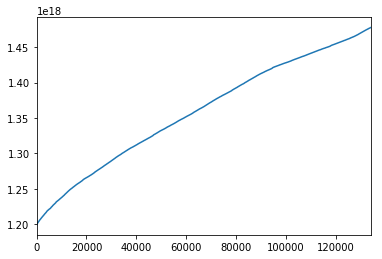

In [5]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts).value).plot();

**Чтобы ответить на вопросы 1 и 2, можно использовать [pandas.DataFrame.corr()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html), [pandas.to_datetime()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html) и [pandas.Series.value_counts()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html)**

<font color='red'>Вопрос 1.</font> Есть ли в train_df признаки, корреляция между которыми больше 0.9? Обратите внимание, именно различные признаки - корреляция признака с самим собой естественно больше 0.9 :)
- да
- **нет**
- не знаю

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

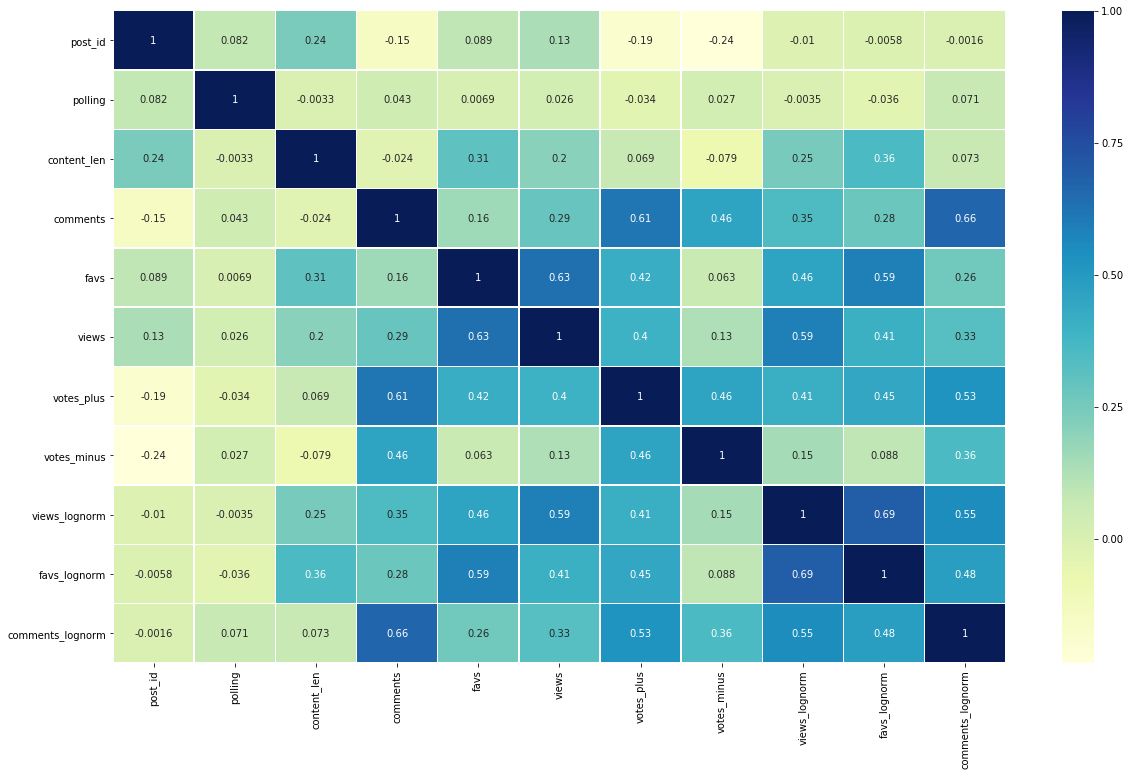

In [36]:
#method 1 
plt.figure(figsize=(20, 12))
sns.heatmap (train_df.corr(),annot=True, linewidths=.5,  cmap="YlGnBu" )

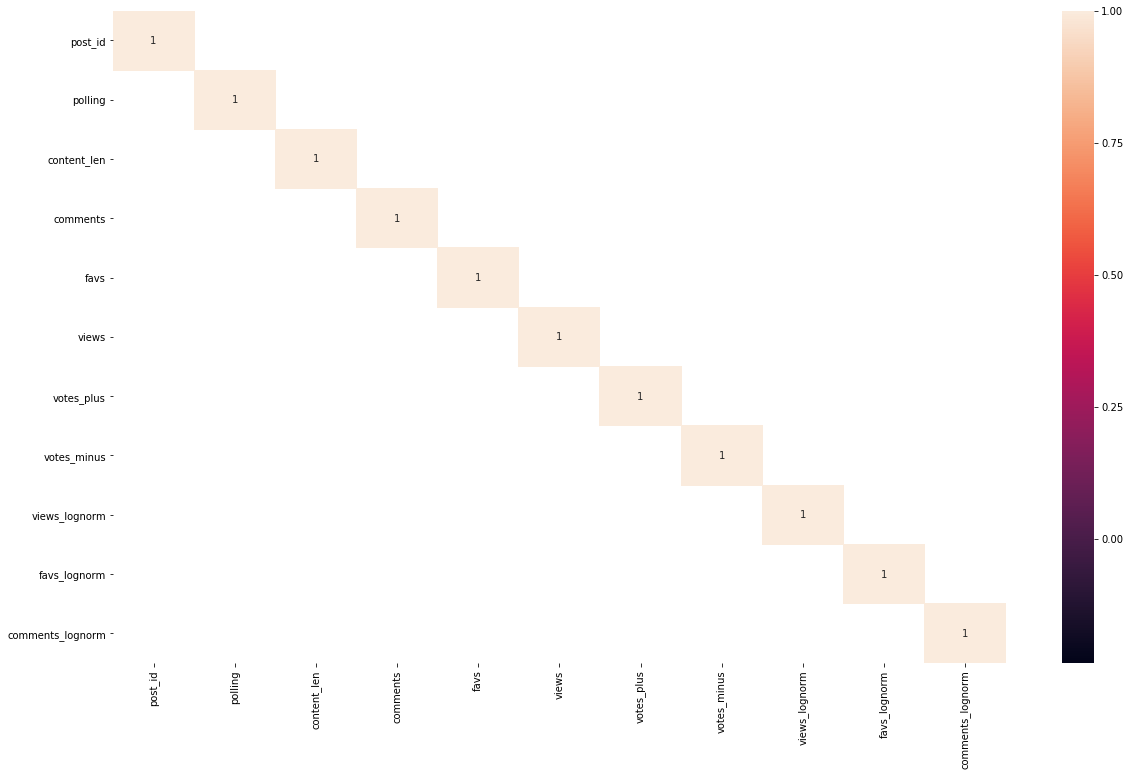

In [37]:
# method 2 
plt.figure(figsize=(20, 12))
mask = np.zeros_like(train_df.corr())
mask[train_df.corr() < 0.9 ] = True #don't show cells with values lower than 0.9 
sns.heatmap(train_df.corr(), mask = mask, annot = True  )

In [38]:
train_df.corr() > 0.9

,post_id,polling,content_len,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
post_id,True,False,False,False,False,False,False,False,False,False,False
polling,False,True,False,False,False,False,False,False,False,False,False
content_len,False,False,True,False,False,False,False,False,False,False,False
comments,False,False,False,True,False,False,False,False,False,False,False
favs,False,False,False,False,True,False,False,False,False,False,False
views,False,False,False,False,False,True,False,False,False,False,False
votes_plus,False,False,False,False,False,False,True,False,False,False,False
votes_minus,False,False,False,False,False,False,False,True,False,False,False
views_lognorm,False,False,False,False,False,False,False,False,True,False,False
favs_lognorm,False,False,False,False,False,False,False,False,False,True,False


<font color='red'>Вопрос 2.</font> В каком году было больше всего публикаций? (Рассматриваем train_df)
- 2014
- **2015**
- 2016
- 2017

In [48]:
train_df['published'] = pd.to_datetime(train_df['published'])
train_df['year'] = train_df['published'].apply ( lambda x : x.year )

In [60]:
train_df['year'].value_counts().sort_values(ascending=False).index[0]

2015

## Разбиение на train/valid
Используем только признаки 'author', 'flow', 'domain' и 'title'

In [63]:
features = ['author', 'flow', 'domain','title']
train_size = int(0.7 * train_df.shape[0])

In [64]:
len(train_df),train_size

(134137, 93895)

In [67]:
X, y = train_df.loc[:, features],  train_df['favs_lognorm'] #отделяем признаки от целевой переменной

X_test = test_df.loc[:, features]

In [68]:
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]

y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

## Применение TfidfVectorizer

**TF-IDF** (от англ. TF — term frequency, IDF — inverse document frequency) — статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален количеству употребления этого слова в документе, и обратно пропорционален частоте употребления слова в других документах коллекции. [Подробнее в источнике](https://ru.wikipedia.org/wiki/TF-IDF)

TfidfVectorizer преобразует тексты в матрицу TF-IDF признаков.

**Основные параметры TfidfVectorizer в sklearn:**
- **min_df** - при построении словаря слова, которые встречаются *реже*, чем указанное значение, игнорируются
- **max_df** - при построении словаря слова, которые встречаются *чаще*, чем указанное значение, игнорируются
- **analyzer** - определяет, строятся ли признаки по словам или по символам (буквам)
- **ngram_range** - определяет, формируются ли признаки только из отдельных слов или из нескольких слов (в случае с analyzer='char' задает количество символов). Например, если указать analyzer='word' и ngram_range=(1,3),то признаки будут формироваться из отдельных слов, из пар слов и из троек слов.
- **stop_words** - слова, которые игнорируются при построении матрицы

Более подробно с параметрами можно ознакомиться в [документации](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

**Инициализируйте TfidfVectorizer с параметрами min_df=3, max_df=0.3 и ngram_range=(1, 3).<br />
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

<font color='red'>Вопрос 3.</font> Какой размер у полученного словаря?
- 43789
- **50624**
- 93895
- 74378

In [77]:
counter  = TfidfVectorizer(min_df=3, max_df=0.3, ngram_range=(1, 3))
X_train_title = counter.fit_transform(X_train['title'])
X_valid_title = counter.transform(X_valid['title'])
X_test_title = counter.transform(X_test['title'])

In [83]:
len(counter.vocabulary_)

50624

<font color='red'>Вопрос 4.</font> Какой индекс у слова 'python'?
- 1
- 10
- **9065**
- 15679

In [85]:
counter.vocabulary_.get('python')

9065

**Инициализируйте TfidfVectorizer, указав analyzer='char'.<br />
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

<font color='red'>Вопрос 5.</font> Какой размер у полученного словаря?
- **218**
- 510
- 125
- 981

In [87]:
counter_char = TfidfVectorizer(analyzer='char')
X_train_title_char = counter_char.fit_transform(X_train.title) 
X_valid_title_char = counter_char.transform(X_valid.title )
X_test_title_char = counter_char.transform(X_test.title)

In [89]:
len(counter_char.vocabulary_)

218

## Работа с категориальными признаками

Для обработки категориальных признаков 'author', 'flow', 'domain' мы будем использовать DictVectorizer из sklearn.

In [134]:
feats = ['author', 'flow', 'domain']
X_train[feats][:5].fillna('-').T.to_dict().values()

dict_values([{'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}])

In [135]:
dict_vect = DictVectorizer()
dict_vect_matrix = dict_vect.fit_transform(X_train[feats][:5].fillna('-').T.to_dict().values())
dict_vect_matrix 

<5x9 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [136]:
dict_vect_matrix.toarray()

array([[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.]])

In [90]:
feats = ['author', 'flow', 'domain']
X_train[feats][:5]

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,NaN,geektimes.ru


Рассмотрим как он работает на примере первых пяти строк

In [91]:
#сначала заполняем пропуски прочерком
X_train[feats][:5].fillna('-')

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,-,geektimes.ru


In [92]:
#Преобразуем датафрейм в словарь, где ключами являются индексы объектов (именно для этого мы транспонировали датафрейм),
#а значениями являются словари в виде 'название_колонки':'значение'
X_train[feats][:5].fillna('-').T.to_dict()

{0: {'author': '@Tapac', 'domain': 'habrahabr.ru', 'flow': 'develop'},
 1: {'author': '@DezmASter', 'domain': 'habrahabr.ru', 'flow': 'design'},
 2: {'author': '@DezmASter', 'domain': 'habrahabr.ru', 'flow': 'design'},
 3: {'author': '@Taoorus', 'domain': 'habrahabr.ru', 'flow': 'design'},
 4: {'author': '@dennydo', 'domain': 'geektimes.ru', 'flow': '-'}}

In [93]:
#В DictVectorizer нам нужно будет передать список словарей для каждого объекта в виде 'название_колонки':'значение',
#поэтому используем .values()
X_train[feats][:5].fillna('-').T.to_dict().values()

dict_values([{'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}])

In [110]:
#В итоге получается разреженная матрица
dict_vect = DictVectorizer()
dict_vect_matrix = dict_vect.fit_transform(X_train[feats][:5].fillna('-').T.to_dict().values())
dict_vect_matrix

<5x9 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [137]:
#Но можно преобразовать ее в numpy array с помощью .toarray()
dict_vect_matrix.toarray()

array([[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.]])

In [138]:
#В получившейся матрице 5 строк (по числу объектов) и 9 столбцов
#Далее разберемся почему колонок именно 9
dict_vect_matrix.shape

(5, 9)

Посмотрим сколько уникальных значений в каждой колонке.<br />
Суммарно их 9 - столько же, сколько и колонок. Это объясняется тем, что для категориальных признаков со строковыми значениями DictVectorizer делает кодирование бинарными признаками - каждому уникальному значению признака соответствует один новый бинарный признак, который равен 1 только в том случае, если в исходной матрице этот признак принимает значение, которому соответствует эта колонка новой матрицы.

In [139]:
for col in feats:
    print(col,len(X_train[col][:5].fillna('-').unique()))

author 4
flow 3
domain 2


Также можно посмотреть что означает каждая колонка полученной матрицы

In [140]:
#например, самая первая колонка называется 'author=@DezmASter' - то есть принимает значение 1 только если автор @DezmASter
dict_vect.feature_names_

['author=@DezmASter',
 'author=@Taoorus',
 'author=@Tapac',
 'author=@dennydo',
 'domain=geektimes.ru',
 'domain=habrahabr.ru',
 'flow=-',
 'flow=design',
 'flow=develop']

**Инициализируйте DictVectorizer с параметрами по умолчанию.<br />
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

In [146]:
vectorizer_feats = DictVectorizer()

X_train_feats = vectorizer_feats.fit_transform(X_train.loc[:, feats].fillna('-').T.to_dict().values())
X_valid_feats = vectorizer_feats.transform(X_valid.loc[:, feats].fillna('-').T.to_dict().values())
X_test_feats = vectorizer_feats.transform(X_test.loc[:, feats].fillna('-').T.to_dict().values())

In [147]:
X_train_feats.shape

(93895, 17869)

Соединим все полученные матрицы при помощи scipy.sparse.hstack()

In [148]:
X_train_new = scipy.sparse.hstack([X_train_title, X_train_feats, X_train_title_char])
X_valid_new = scipy.sparse.hstack([X_valid_title, X_valid_feats, X_valid_title_char])
X_test_new =  scipy.sparse.hstack([X_test_title, X_test_feats, X_test_title_char])

## Обучение модели

Далее будем использовать Ridge, линейную модель с l2-регуляризацией.
[Документация](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

Основной параметр Ridge - **alpha, коэффициент регуляризации**. Регуляризация используется для улучшения обобщающей способности модели - прибавляя к функционалу потерь сумму квадратов весов, умноженную на коэффициент регуляризации (та самая alpha), мы штрафуем модель за слишком большие значения весов и не позволяем ей переобучаться. Чем больше этот коээфициент, тем сильнее эффект.

**Обучите две модели на X_train_new, y_train, задав в первой alpha=0.1 и random_state = 1, а во второй alpha=1.0 и random_state = 1**

**Рассчитайте среднеквадратичную ошибку каждой модели (mean_squared_error). Сравните значения ошибки на обучающей и тестовой выборках и ответьте на вопросы.**

????

<font color='red'>Вопрос 6.</font> Выберите верные утверждения:
- обе модели показывают одинаковый результат (среднеквадратичная ошибка отличается не больше чем на тысячные), регуляризация ничего не меняет
- **при alpha=0.1 модель переобучается**
- среднеквадратичная ошибка первой модели на тесте меньше
- **при alpha=1.0 у модели обощающая способность лучше, чем у при alpha=0.1**

In [182]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('clf', Ridge(random_state=1)),
    ])

In [184]:
pipeline.set_params(clf__alpha=0.1)
predicted_valid = pipeline.fit(X_train_new, y_train).predict(X_valid_new)
predicted_train = pipeline.predict(X_train_new)
print('alpha = 0.1',
      '\nMSE on test data: ', mean_squared_error(y_valid, predicted_valid),
      '\nMSE on train data : ', mean_squared_error(y_train, predicted_train)) 

pipeline.set_params(clf__alpha=1.0)
predicted_valid = pipeline.fit(X_train_new, y_train).predict(X_valid_new)
predicted_train = pipeline.predict(X_train_new)
print('alpha = 1.0',
      '\nMSE on test data: ', mean_squared_error(y_valid, predicted_valid),
      '\nMSE on train data : ', mean_squared_error(y_train, predicted_train)) 

alpha = 0.1 
MSE on test data:  0.902647554634 
MSE on train data :  0.184107031582
alpha = 1.0 
MSE on test data:  0.701144627434 
MSE on train data :  0.28624407471


## Baseline

**Теперь попытаемся получить бейзлайн для соревования - используйте Ridge с параметрами по умолчанию и обучите модель на всех данных - соедините X_train_new X_valid_new (используйте scipy.sparse.vstack()), а целевой переменной будет y.**

In [194]:
full_X = scipy.sparse.vstack([X_train_new, X_valid_new])
pipeline.set_params(clf__alpha=1.)
predictions = pipeline.fit(full_X, y).predict(X_test_new)

In [196]:
write_to_submission_file(predictions, 'baseline_hw_4_2.csv')

In [195]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)